# Assignment 1 DD2358
 Group 17: Felix Schätzle, Georgios Mitsos, Thorben Fetz

## Task 1.1: Calculate the Clock Granularity of different Python Timers

In [1]:
import numpy as np
import time
import timeit
import psutil

In [2]:
#time.time()

def checktick():
    M = 200
    timesfound = np.empty((M,))
    for i in range(M):
        t1 =  time.time() # get timestamp from timer
        t2 = time.time() # get timestamp from timer
        while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
            t2 = time.time() # get timestamp from timer
        t1 = t2 # this is outside the loop
        timesfound[i] = t1 # record the time stamp
    minDelta = 1000000
    Delta = np.diff(timesfound) # it should be cast to int only when needed
    minDelta = Delta.min()
    return minDelta

print(f"Granularity for time.time(): {checktick():.2E} seconds")


Granularity for time.time(): 7.15E-07 seconds


In [3]:
#time.time_ns()

def checktick():
    M = 200
    timesfound = np.empty((M,))
    for i in range(M):
        t1 =  time.time_ns() # get timestamp from timer
        t2 = time.time_ns() # get timestamp from timer
        while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
            t2 = time.time_ns() # get timestamp from timer
        t1 = t2 # this is outside the loop
        timesfound[i] = t1 # record the time stamp
    minDelta = 1000000
    Delta = np.diff(timesfound) # it should be cast to int only when needed
    minDelta = Delta.min()
    return minDelta/1e9

print(f"Granularity for time.time_ns(): {checktick():.2E} seconds")


Granularity for time.time_ns(): 7.68E-07 seconds


In [20]:
# timeit.timeit()

def checktick():
   M = 200
   timesfound = np.empty((M,))
   for i in range(M):
      t1 =  timeit.default_timer() # get timestamp from timer
      t2 = timeit.default_timer() # get timestamp from timer
      while (t2 - t1) < 1e-16: # if zero then we are below clock granularity, retake timing
          t2 = timeit.default_timer() # get timestamp from timer
      t1 = t2 # this is outside the loop
      timesfound[i] = t1 # record the time stamp
   #minDelta = 1000000
   Delta = np.diff(timesfound) # it should be cast to int only when needed
   minDelta = Delta.min()
   return minDelta

print(f"Granularity for timeit: {checktick():.2E} seconds")


Granularity for timeit: 2.50E-07 seconds


## Task 1.2: Timing the Julia set code functions

Due to lack of computing power on our laptop, we run the function with the following arguments: 

calc_pure_python(desired_width=1000, max_iterations=300) 

The best timer from Task 1.1 was timeit.default_timer() so it is used in the present Task. 

In order to calculate the average and the standard deviation of the running time, we run the code N=40 times.

Using this decorator:

In [32]:
import timeit
from functools import wraps

global t_diff
t_diff = []

def timefn(fn):
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 =  timeit.default_timer()
        result = fn(*args, **kwargs)
        t2 =  timeit.default_timer()
        t_diff.append(t2-t1)
        return result
    return measure_time


In [33]:
@timefn
def calc_pure_python(desired_width, max_iterations):
    """Create a list of complex coordinates (zs) and complex parameters (cs),
    build Julia set"""
    x_step = (x2 - x1) / desired_width
    y_step = (y1 - y2) / desired_width
    x = []
    y = []
    ycoord = y2
    while ycoord > y1:
        y.append(ycoord)
        ycoord += y_step
    xcoord = x1
    while xcoord < x2:
        x.append(xcoord)
        xcoord += x_step
    # build a list of coordinates and the initial condition for each cell.
    # Note that our initial condition is a constant and could easily be removed,
    # we use it to simulate a real-world scenario with several inputs to our
    # function
    zs = []
    cs = []
    for ycoord in y:
        for xcoord in x:
            zs.append(complex(xcoord, ycoord))
            cs.append(complex(c_real, c_imag))
    
    output = calculate_z_serial_purepython(max_iterations, zs, cs)


@timefn
def calculate_z_serial_purepython(maxiter, zs, cs):
    """Calculate output list using Julia update rule"""
    output = [0] * len(zs)
    for i in range(len(zs)):
        n = 0
        z = zs[i]
        c = cs[i]
        while abs(z) < 2 and n < maxiter:
            z = z * z + c
            n += 1
        output[i] = n
    return output

N = 40 # run N times to calculate average and standard deviation
for i in range(N): 
    calc_pure_python(desired_width=1000, max_iterations=300)
    
print(f"calculate_z_serial_purepython took on average {np.mean(t_diff[0::2])} seconds with a standard deviation of {np.std(t_diff[0::2])} seconds")
print(f"calc_pure_python took on average {np.mean(t_diff[1::2])} seconds with a standard deviation of {np.std(t_diff[1::2])} seconds")


calculate_z_serial_purepython took on average 1.9102803541478353 seconds with a standard deviation of 0.05308210634755559 seconds
calc_pure_python took on average 2.021204278121877 seconds with a standard deviation of 0.05797843476566862 seconds


## Task 1.3: Profile the Julia set code with cProvile and line_profiler

In [40]:
%run -i -m cProfile -o profile.stats -s cumulative JuliaSet.py


Length of x: 1000
Total elements: 1000000
calculate_z_serial_purepython took 20.547204971313477 seconds


### Results of cProfile in Snakeviz
python -m snakeviz profile.stats --server

![SnakeViz graph](snakeviz.png)

In [36]:
# %run -i -m kernprof -l JuliaSet.py
%run -i -m line_profiler JuliaSet.py.lprof

Timer unit: 1e-06 s

Total time: 96.9572 s
File: JuliaSet.py
Function: calc_pure_python at line 9

Line #      Hits         Time  Per Hit   % Time  Line Contents
     9                                           @profile
    10                                           def calc_pure_python(desired_width, max_iterations):
    11                                               """Create a list of complex coordinates (zs) and complex parameters (cs),
    12                                               build Julia set"""
    13         1          3.0      3.0      0.0      x_step = (x2 - x1) / desired_width
    14         1          0.0      0.0      0.0      y_step = (y1 - y2) / desired_width
    15         1          1.0      1.0      0.0      x = []
    16         1          0.0      0.0      0.0      y = []
    17         1          0.0      0.0      0.0      ycoord = y2
    18      1001        577.0      0.6      0.0      while ycoord > y1:
    19      1000        442.0      0.4      0.

### Overhead added by cProfiler and line_profiler

| Function | timeit | cProfile | line_profile |
|---|--- | --- | --- |
|calc_pure_python| 8.1 | 20 | 96.96 |
|calc_serial_purepython | 7.4 | 19.7 | 46.55 |


| Function | cProfile overhead | line_profile overhead |
|---|--- | --- | 
|calc_pure_python| 11.9 | 88.86 |
|calc_serial_purepython | 12.3 | 39.15 |


### Task 1.4: Memory profiling

desired_width is set equal to 100 for the present Task.

In [37]:
%run -m memory_profiler JuliaSet_memory.py

Filename: JuliaSet_memory.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    11   94.734 MiB   94.734 MiB           1   @profile
    12                                         def calc_pure_python(desired_width, max_iterations):
    13                                             """Create a list of complex coordinates (zs) and complex parameters (cs),
    14                                             build Julia set"""
    15   94.734 MiB    0.000 MiB           1       x_step = (x2 - x1) / desired_width
    16   94.734 MiB    0.000 MiB           1       y_step = (y1 - y2) / desired_width
    17   94.734 MiB    0.000 MiB           1       x = []
    18   94.734 MiB    0.000 MiB           1       y = []
    19   94.734 MiB    0.000 MiB           1       ycoord = y2
    20   94.766 MiB    0.000 MiB         101       while ycoord > y1:
    21   94.766 MiB    0.031 MiB         100           y.append(ycoord)
    22   94.766 MiB    0.000 MiB         100           ycoord +=

desired_width is changed back to 1000.

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


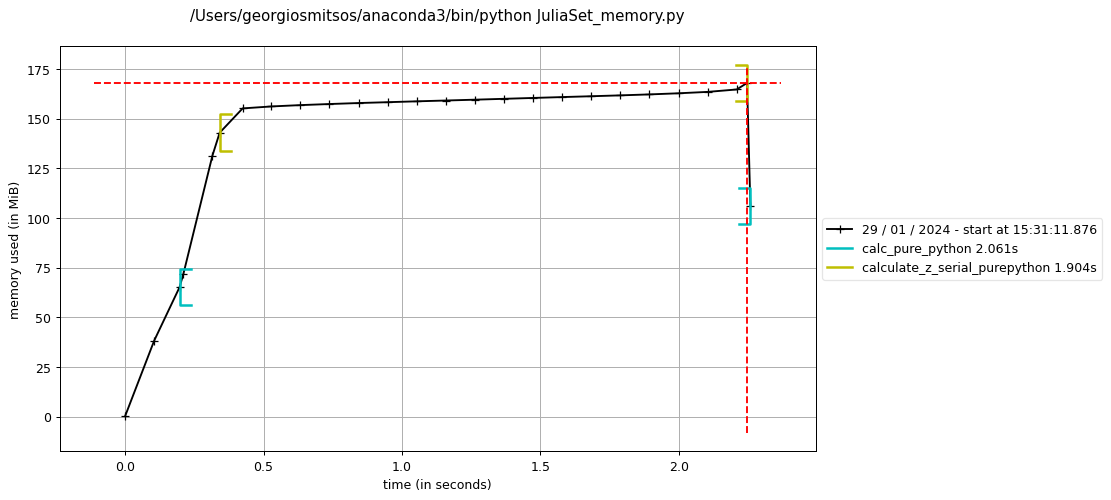

In [47]:
%run -m mprof run --output mprofile_julia.dat JuliaSet_memory.py
%run -m mprof plot mprofile_julia.dat

### Overhead added by memory_rofiler and mprof

As expected mprof adds a negligible overhead, while memory_profiler importantly increases the running time.

| Function | memory_profiler overhead (desired_width=100) | mprof overhead (desired_width=1000) |
| --- | --- | --- | 
|calc_pure_python| 8.87 | 0.04 |
|calc_serial_purepython | 8.53 | 0.01 |


# Task 2.1: Profile the diffusion process code
## cProfile

In [55]:
%run -i -m cProfile -o profile_diffusion.stats -s cumulative DiffusionProcess.py

### cProfile output visualized using snakeviz
python -m snakeviz profile_diffusion.stats --server

Note: The call graph was not very interesting in this case, shown below is the more detailed view by function

![Snakeviz cprofile](snakeviz_diffusion.png)

In [57]:
%run -i -m kernprof -l DiffusionProcess.py
%run -i -m line_profiler DiffusionProcess.py.lprof

Wrote profile results to DiffusionProcess.py.lprof
Inspect results with:
python -m line_profiler -rmt "DiffusionProcess.py.lprof"
Timer unit: 1e-06 s

Total time: 0.082064 s
File: DiffusionProcess.py
Function: evolve at line 5

Line #      Hits         Time  Per Hit   % Time  Line Contents
     5                                           @profile
     6                                           def evolve(grid, dt, D=1.0):
     7         5          9.0      1.8      0.0      xmax, ymax = grid_shape
     8       325       1379.0      4.2      1.7      new_grid = [[0.0] * ymax for x in range(xmax)]
     9       325        245.0      0.8      0.3      for i in range(xmax):
    10     20800      14077.0      0.7     17.2          for j in range(ymax):
    11     20480      10255.0      0.5     12.5              grid_xx = (
    12     20480      17026.0      0.8     20.7                  grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
    13                             

## Task 2.2: Memory profile the diffusion code

In [54]:
%run -m memory_profiler DiffusionProcess.py

Filename: DiffusionProcess.py

Line #    Mem usage    Increment  Occurrences   Line Contents
     5  247.203 MiB 2359.641 MiB          10   @profile
     6                                         def evolve(grid, dt, D=1.0):
     7  247.203 MiB    0.000 MiB          10       xmax, ymax = grid_shape
     8  249.609 MiB   14.766 MiB        6430       new_grid = [[0.0] * ymax for x in range(xmax)]
     9  252.609 MiB -13544.969 MiB        6410       for i in range(xmax):
    10  252.609 MiB -8692643.188 MiB     4102400           for j in range(ymax):
    11  252.609 MiB -8679029.141 MiB     4096000               grid_xx = (
    12  252.609 MiB -8679098.219 MiB     4096000                   grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
    13                                                     )
    14  252.609 MiB -8679066.250 MiB     4096000               grid_yy = (
    15  252.609 MiB -8679066.250 MiB     4096000                   grid[i][(j + 1) % ymax] + grid[i

mprof.py: Sampling memory every 0.1s
running new process
running as a Python program...


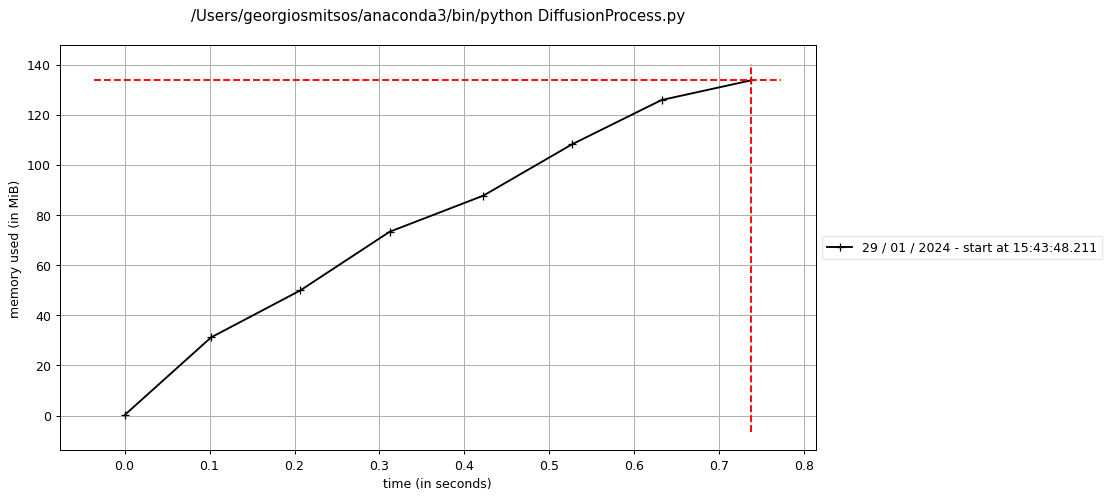

In [48]:
%run -m mprof run --output mprofile_diffusion.dat DiffusionProcess.py
%run -m mprof plot mprofile_diffusion.dat

### Overhead added by memory_rofiler and mprof

Without the memory profilers, for num_iterations = 10, the code runs in 0.71 seconds.

| memory_profiler overhead | mprof overhead |
| --- | --- | 
| 208.15 | 0.02 |


## Bonus Exercise: Profiler Tool for Monitoring CPU Usage
We developed our profiler as Python class in [CPUMonitor.py](CPUMonitor.py). It records the CPU percentage of every core on a system either during a specified amount of time or as long as a program is running. The values are printed to the terminal, plotted and saved for future reference (see [julia_set.csv](julia_set.csv) and [diffusion_process.csv](diffusion_process.csv) for precise values and the graphs below for an overall trend). 


![Julia_set](julia_set.png)
![Diffusion_process](diffusion_process.png)


Because a large number of processes are usually running simultaneously on our computers, the measurements are not very consistent between different runs. For long and CPU-intensive programs, it usually becomes possible to determine which cores they were run on, as these have load spikes for the duration of the program execution. Thereby one can deduce how parallelized the program currently is. 